In [1]:
import tensorflow as tf
print(tf.__version__)

2025-03-04 02:20:45.618246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 02:20:48.038137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/11.8/lib64:/shared/centos7/nodejs/14.15.4/lib
2025-03-04 02:20:48.038242: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/11.8/lib64:/shared/centos7/nodejs/

2.11.0


### This notebook is for Sina to run the 3D segmentation and extract the centriod of the neurons

- install tensorflow and stardist

In [2]:
import tensorflow as tf
from stardist import __version__ as stardist_version
print("TensorFlow version:", tf.__version__)
print("StarDist version:", stardist_version)

TensorFlow version: 2.11.0
StarDist version: 0.9.1


- load the modules

In [3]:
import sys
import os
from func_seg import *

True
Tesla V100-SXM2-32GB
True
2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


- load stardist 3D and model weights

In [4]:
model_weights_path = 'weights_best_42stacks_all.h5'
model, model_2D = load_model_3D_and_2D(model_weights_path)

use_gpu:  True


base_model.py (203): output path for model already exists, files may be overwritten: /work/venkatachalamlab/Hang/Jin/Segmentation/seg/models/stardist
2025-03-04 02:21:00.310102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 02:21:00.454438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.
There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


- specify the dataset path, channel, saved folder
- the data.h5 store [frame, channel, depth, width, heighth]
- obtain the raw segmentation 

In [5]:
# dataset_path = Path('/work/venkatachalamlab/Hang/00Identify_neuron/datasets/sexual_dimorphism_frame/male/20220329_male_10_processed')
dataset_path = Path('/work/venkatachalamlab/Hang/Jin')
ch = 1 ## specify the channel to segmentation
zoom_factor = 1
seg_path = dataset_path/'seg' ## saved folder
seg_path.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
t_idx = 100 ## select which frame
gamma = 0.1

## hey Jin, this is the raw segmentation from the trained 3D stardist

In [6]:
import matplotlib.pyplot as plt

In [7]:
img_original,_ = get_volume_at_frame(os.path.join(dataset_path,'data.h5'),t_idx)    
img_zoom = scipy.ndimage.zoom(img_original[0,ch],[1,zoom_factor,zoom_factor],order = 0)


if gamma is not None:
    img_zoom = gamma_correction(img_zoom, gamma)

img_norm = normalize(img_zoom, 1,95.8)
img_proj_pred = get_mask_from_proj_pred(model_2D,img_zoom)
np.unique(img_proj_pred).shape,  ## the number of found neurons,

2025-03-04 02:21:02.806762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8903


((17,),)

In [8]:
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max, corner_peaks
from skimage.measure import label
from scipy import ndimage as ndi
import numpy as np  
from glob import glob
# from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
import stardist
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.plot import render_label

from scipy import ndimage
import skimage
import copy

from skimage.measure import regionprops_table
import pandas as pd

def get_merged_label(labels_xy_slice):
    properties = ['label', 'coords']

    region_props = regionprops_table(labels_xy_slice, properties=properties)
    region_props_df = pd.DataFrame(region_props)

    offsets = np.array([[-1, -1], [-1, 0], [-1, 1],
                        [0, -1],  [0, 0],   [0, 1],
                        [1, -1],  [1, 0],   [1, 1]])
    region_props_df['nearby_label'] = [None] * len(region_props_df)
    region_props_df['num_nearby_label'] = [None] * len(region_props_df)
    # image_shape = labels_xy_slice.shape
    for i in range(len(region_props_df)):
        coords = region_props_df['coords'][i]  # Shape (N, 2)
        connected_points = coords[:, np.newaxis, :] + offsets  # Shape (N, 9, 2) 
        ## since padded image, so the nearby boundary must be within the bound of the padded image
        connected_points = connected_points.reshape(-1, 2)
        connected_points = connected_points[(connected_points[:,0]>=0) &
                                            (connected_points[:,0]<labels_xy_slice.shape[0]) & 
                                            (connected_points[:,1]>=0) & 
                                            (connected_points[:,1]<labels_xy_slice.shape[1])]

        seg_ID = labels_xy_slice[connected_points[:,0],connected_points[:,1]]
        region_props_df.at[i, 'nearby_label'] = np.unique(seg_ID[seg_ID>0])
        region_props_df.at[i, 'num_nearby_label'] = len(np.unique(seg_ID[seg_ID>0]))


    nearby_label = region_props_df['label'][region_props_df['num_nearby_label']>1].values
    return nearby_label
        
def find_overlapping_contours(labels_xy_slice):
        # unique_labels = np.unique(labels_xy_slice[labels_xy_slice>0])
        unique_labels = get_merged_label(labels_xy_slice)
        if len(unique_labels)>0:
            contours = [] 
            for label in unique_labels:
                contour = skimage.measure.find_contours((labels_xy_slice == label)*1, 0)[0]
                contours += np.unique(contour, axis=0).tolist()

            contours = np.array(contours).astype(int).reshape(-1,2)


            # Ensure contours is at least 2D before indexing
            # if len(contours.shape) == 1:
            #     raise ValueError("Contours array is 1-dimensional, expected 2-dimensional.")
            

            ind = (labels_xy_slice[contours[:, 0], contours[:, 1]]>0)
            nearby_points = contours[ind]
            return nearby_points
        else:
            return []


def remove_overlapping_contours(labels_xy):
        labels_xy_isolated = copy.deepcopy(labels_xy)
        for z in range(labels_xy.shape[0]):
            labels_xy_slice = labels_xy[z]
            if not np.all(labels_xy[z] == 0):
                nearby_points = find_overlapping_contours(labels_xy_slice)
                if len(nearby_points)>0:
                    labels_xy_isolated[z, nearby_points[:, 0], nearby_points[:, 1]] = 0
        return labels_xy_isolated


def apply_watershed_3d(labels_xy):
    voxel_spacing = (1.0, 1.0, 1.0)  
    distance = distance_transform_edt(labels_xy > 0, sampling=voxel_spacing)
    
    # local_maxi = peak_local_max(distance, 
    #                             # indices=False, 
    #                             footprint=np.ones((3,3,3)), 
    #                             labels=stack)


    local_maxi = corner_peaks(distance, min_distance=5)  # Adjust `min_distance` as needed

    
    local_maxi_mask = np.zeros_like(distance, dtype=bool)
    local_maxi_mask[tuple(local_maxi.T)] = True
    # markers,_ = ndi.label(local_maxi_mask)
    markers = label(local_maxi_mask)

    

    labels = watershed(-distance*(labels_xy>0) , 
                       markers.astype(np.int32), 
                       mask=labels_xy.astype(bool)
                      )
    
    return labels

def get_stack_seg(img_zoom):
    img_z_slice = []
    depth = img_zoom.shape[0]
    for z in range(depth):
        img_xy = normalize(img_zoom[z],1,90)
        # img_xy = img_norm[z]
        # label_z, _ = model_2D.predict_instances(img_xy* (img_proj_pred>0))
        label_z, _ = model_2D.predict_instances(img_xy)
        img_z_slice.append(label_z)
    img_z_slice = np.array(img_z_slice)
    return img_z_slice

img_z_slice = get_stack_seg(img_zoom) ### please note here using (1,90) to nomalize the bright area
labels_xy = remove_overlapping_contours(img_z_slice)
segmented_stack = apply_watershed_3d(labels_xy)
len(np.unique(segmented_stack))


25

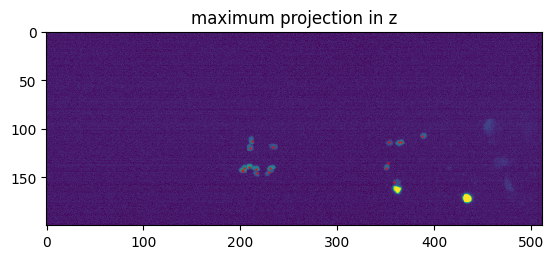

In [14]:
from load_func import *
combined_df_t_idx = load_annotations_h5_t_idx(dataset_path/'annotations.h5',t_idx)
pos = get_abs_pos(combined_df_t_idx,segmented_stack.shape)
img_plot = img_zoom.max(0)
# plt.imshow(img_proj_pred)
plt.imshow(img_plot)
plt.plot(pos[:,2],pos[:,1],'r.',markersize = 1)
plt.title("maximum projection in z")
plt.show()

In [ ]:
for z in range(25):
    plt.figure(figsize =(10, 5)) 
    plt.imshow(segmented_stack[z], cmap=plt.cm.tab20)  # Use `cmap` instead of `color` 
    # plt.imshow(img_original[0,ch,z]) 
    # plt.imshow(adjusted[z])
    # plt.imshow(img_norm[z])
    ind = pos[:,0] ==z
    if np.sum(ind)>0:
        plt.plot(pos[ind,2],pos[ind,1],'r.',markersize = 5)
    plt.title(z)
    plt.show() 

- extract the centroid from the segmentation
- use these centroid to group the 2D segmented nuclei
- apply watershed algorithm

### **3D Region Properties in `regionprops_table`**
| Property                         | Description |
|----------------------------------|-------------|
| `'centroid'`                     | Center of mass (x, y, z) |
| `'area'`                         | Number of voxels in the region |
| `'bbox'`                         | Bounding box (min/max in x, y, z) |
| `'axis_major_length'`            | Largest principal axis length (3D equivalent of major axis) |
| `'axis_minor_length'`            | Smallest principal axis length |
| `'equivalent_diameter'`          | Diameter of a sphere with the same volume |
| `'extent'`                       | Ratio of voxel volume to bounding box volume |
| `'solidity'`                     | Ratio of voxel volume to convex hull volume |
| `'convex_area'`                  | Number of voxels in the convex hull |
| `'convex_volume'`                | Volume of the convex hull |
| `'eccentricity'`                 | Measure of how elongated the object is |
| `'euler_number'`                 | Number of connected components minus holes |
| `'feret_diameter_max'`           | Maximum distance between two boundary points |
| `'perimeter'`                    | Perimeter in pixels along the object surface |
| `'sphericity'`                   | Measures how close the shape is to a sphere (higher = more spherical) |
| `'max_intensity'`                | Maximum intensity in the region |
| `'mean_intensity'`               | Mean intensity |
| `'min_intensity'`                | Minimum intensity |
| `'standard_deviation_intensity'` | Standard deviation of intensities |
| `'sum_intensity'`                | Sum of all intensity values in the region |
"""

In [16]:
from skimage.measure import regionprops
props = regionprops_table(
    segmented_stack ,
    properties=('centroid','area'),
)
## 'centroid' is the coordinates of neurons
pd.DataFrame(props)

,centroid-0,centroid-1,centroid-2,area
0,4.704380,114.266423,366.927007,274.0
1,5.426304,134.665533,468.727891,882.0
2,6.564706,139.470588,351.747059,170.0
3,6.030075,141.067669,217.015038,133.0
4,6.248780,142.287805,203.258537,205.0
5,6.355910,171.877822,435.195219,753.0
6,7.565217,140.097826,231.885870,184.0
7,8.199183,98.087845,457.347293,979.0
8,8.339623,111.547170,461.698113,53.0
9,8.482759,112.517241,457.844828,58.0
